In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import scipy.io as sio
from scipy.interpolate import interp2d
import rppy
import torch
import torchvision
from scipy.ndimage import gaussian_filter


#### Upsample, and adjust geometry of Vp and CO2 Maps

In [4]:
def to_np(input):
    return input.detach().cpu().numpy()

In [ ]:
## Load background velocity model of Frio2
fvel = sio.loadmat('data/general/Frio2_bg_vel.mat')['velocityModel']
#Load vel
vp_all = np.load('data/general/vp_all.npy')
#Load co2
co2_arr =np.load('data/general/co2_all.npy')


Co2Ready = []
VelReady = []
AttnReady = []
for ireal in range(40):
    tempv = []
    tempq = []
    tempco2 = []
    for it in range(39): # from 9 to 47
    
        #sample CO2
        sample_co2 = co2_arr[ireal,it] 
        
        #Velocity P
        sample_vel = vp_all[ireal,it] * 1000
        sample_vel[abs(sample_vel)<1e-4] = 0
        
        #Adjust height and width of plume
        odx = 1.5; odz = 1.5
        ndx = 0.15; ndz = 0.25
        orix = np.arange(0,48*odx,odx)
        oriz = np.arange(0,45*odz,odz)
        newx = np.arange(0,48*odx,ndx)
        newz = np.arange(0,45*odz,ndz)
        f4vel = interp2d(orix,oriz,sample_vel,kind='linear')
        f4co2 = interp2d(orix,oriz,sample_co2,kind='linear')
        intpz_vel = f4vel(newx,newz)
        intpz_co2 = f4co2(newx,newz)
        
        #rotate
        pyt_intpz_vel = torch.tensor(intpz_vel)[None,None,:,:]
        pyt_intpz_co2 = torch.tensor(intpz_co2)[None,None,:,:]
        r_vel = torchvision.transforms.functional.rotate(pyt_intpz_vel,9,fill=0)
        r_co2 = torchvision.transforms.functional.rotate(pyt_intpz_co2,9,fill=0)
        rintpz_vel = to_np(r_vel)[0,0]
        rintpz_co2 = to_np(r_co2)[0,0]
        
        #crop to same size
        onz = 434
        onx = 467
        newtile_vel = np.zeros((onz,onx))
        newtile_co2 = np.zeros((onz,onx))
        newtile_vel[:rintpz_vel.shape[0],:rintpz_vel.shape[1]] = rintpz_vel[:onz,:onx]
        newtile_co2[:rintpz_co2.shape[0],:rintpz_co2.shape[1]] = rintpz_co2[:onz,:onx]
        
        #move things up/down  
        length2move = 103
        pad = np.zeros((length2move,onx))
        newtile_vel = np.concatenate((pad,newtile_vel),axis=0)
        newtile_vel = newtile_vel[:onz,:] 
        newtile_co2 = np.concatenate((pad,newtile_co2),axis=0)
        newtile_co2 = newtile_co2[:onz,:] 
        
        #Patch to background model
        velmod = fvel.copy()
        velmod = velmod + newtile_vel
        
        #background Q
        bgQ = np.ones((434,467)) * 1000
    
        #Reservoir Q
        # vc = fvel.copy()
        gradient = -0.32
        yStarting = 283 #283 is where the reservoir is
        thickness = 90 #thickness of reservoir
        for j in range(yStarting,yStarting+thickness+1): 
            for i in range(467): 
                new_y = round((gradient * i) +j);
                bgQ[new_y,i] = 50
        
        #Plume Q
        plume_mask = abs(newtile_vel) > 0.05
        bgQ[plume_mask] = 25
        
        tempv.append(velmod)
        tempq.append(bgQ)
        tempco2.append(newtile_co2)
    tempv = np.array(tempv)
    tempq = np.array(tempq)
    tempco2 = np.array(tempco2)
    
    VelReady.append(tempv)
    AttnReady.append(tempq)
    Co2Ready.append(tempco2)
    
VelReady = np.array(VelReady)     
AttnReady = np.array(AttnReady)     
Co2Ready = np.array(Co2Ready)


In [ ]:
# np.save('data/general/VelReady.npy',VelReady)
# np.save('data/general/AttnReady.npy',AttnReady)
# np.save('data/general/Co2Ready.npy',Co2Ready)

#### Crop CO2 maps and Vel maps to match source and receiver geometry

In [ ]:
Co2Ready = np.load('data/general/Co2Ready.npy')
VelReady = np.load('data/general/VelReady.npy')


In [ ]:
### Crop CO2 Maps

nx = 467
nz = 434
mask = np.zeros((nz,nx))
#Top half
xStarting = 132
xthickness = 334-132
c1 = 345.92
gradient = -0.8069
for i in range(xStarting,xStarting+xthickness):
    target_y = round((gradient * i) + c1)
    for j in range(239,target_y-1,-1): 
       mask[j,i] = 1
#bottom half       
xStarting = 132
xthickness = 334-132
c2 = 144.9
gradient = 0.7129
for i in range(xStarting,xStarting+xthickness):
    target_y = round((gradient * i) + c2)
    for j in range(target_y,239-1,-1): 
        mask[j,i] = 1

smooth_mask = gaussian_filter(mask, 4)

yTrain_CO2 = []
for ireal in range(40):
    temp=[]
    for its in range(39):
        sco2 = Co2Ready[ireal,its]
        masked_co2 = smooth_mask*sco2
        cropped_co2 = masked_co2[76:383,132:334]
        temp.append(cropped_co2)
    temp = np.array(temp)
    yTrain_CO2.append(temp)
yTrain_CO2 = np.array(yTrain_CO2)

In [ ]:
##### I cropped the CO2 maps to (40,39,300,200) 

yTrain_CO2 = yTrain_CO2[:,:,7:,2:]

In [ ]:
# np.save('data/co2maps/co2_maps.npy',yTrain_CO2)        

#### Check

In [17]:
yTrain_CO2 = np.load('data/co2maps/co2_maps.npy')


In [18]:
print(yTrain_CO2.shape)


(40, 39, 300, 200)


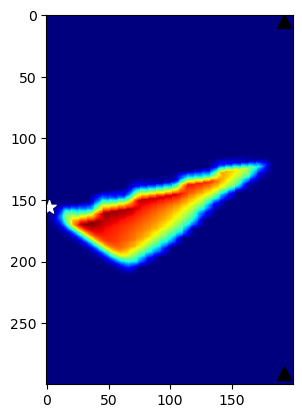

In [9]:
n1 = np.random.randint(40)
n2 = np.random.randint(39)
a = yTrain_CO2[n1,n2]
plt.imshow(a,cmap='jet')
plt.scatter(2,239-76-7,s=100,marker='*',color='white')
plt.scatter(192,5,s=100,marker='^',color='black')
plt.scatter(192,290,s=100,marker='^',color='black')


In [13]:
AttnReady = np.load('data/general/AttnReady.npy')
print(AttnReady.shape)


(40, 39, 434, 467)
